In [1]:
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
import mlflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as RMSE 
import xgboost as xgb

In [2]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval 
from hyperopt.early_stop import no_progress_loss

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("NYC-Taxi-Regressor")

2024/10/04 14:03:08 INFO mlflow.tracking.fluent: Experiment with name 'NYC-Taxi-Regressor' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/MLOps/01-intro/mlruns/3', creation_time=1728050588669, experiment_id='3', last_update_time=1728050588669, lifecycle_stage='active', name='NYC-Taxi-Regressor', tags={}>

In [4]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [5]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [6]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [7]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

In [8]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04


In [9]:
df.duration = df.duration.apply(lambda ld : ld.total_seconds()/60)

In [10]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [11]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [12]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

#### **98% 56.000000 : Most of the trip (98%) duration is within an Hour**
#### we should focus in that range only

In [13]:
df = df[(df.duration >= 1.0) & (df.duration <= 60.0)]

In [14]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [15]:
df.duration.mean()

16.852578430841948

<Axes: xlabel='duration', ylabel='Density'>

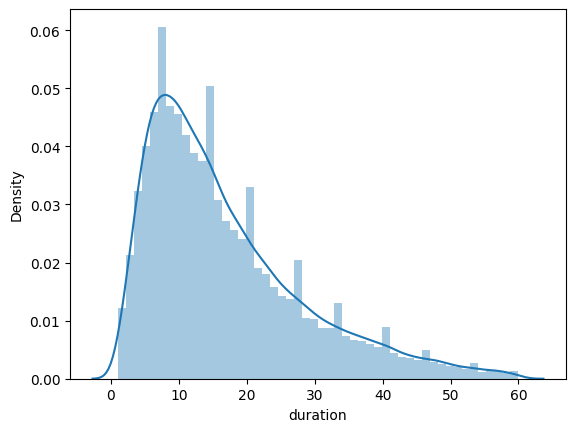

In [16]:
sns.distplot(df.duration)

In [17]:
df.isna().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       35733
RatecodeID               35733
PULocationID                 0
DOLocationID                 0
passenger_count          35733
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                73908
improvement_surcharge        0
total_amount                 0
payment_type             35733
trip_type                35733
congestion_surcharge     35733
duration                     0
dtype: int64

In [18]:
df.drop(columns=['store_and_fwd_flag','RatecodeID','passenger_count','ehail_fee','payment_type','trip_type','congestion_surcharge'],inplace=True)

In [19]:
df.isna().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
PULocationID             0
DOLocationID             0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
duration                 0
dtype: int64

In [20]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,43,151,1.01,5.5,0.5,0.5,0.00,0.0,0.3,6.80,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,166,239,2.53,10.0,0.5,0.5,2.81,0.0,0.3,16.86,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,41,42,1.12,6.0,0.5,0.5,1.00,0.0,0.3,8.30,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,168,75,1.99,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,75,75,0.45,3.5,0.5,0.5,0.96,0.0,0.3,5.76,2.316667


In [21]:
df = df.reset_index()

In [22]:
xvars = ['PULocationID','DOLocationID','trip_distance','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount']
yvars = ['duration']

In [23]:
Xtrain = df[xvars]
ytrain = df[yvars]

In [24]:
Xtrain

,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,43,151,1.01,5.50,0.50,0.5,0.00,0.00,0.3,6.80
1,166,239,2.53,10.00,0.50,0.5,2.81,0.00,0.3,16.86
2,41,42,1.12,6.00,0.50,0.5,1.00,0.00,0.3,8.30
3,168,75,1.99,8.00,0.50,0.5,0.00,0.00,0.3,9.30
4,75,75,0.45,3.50,0.50,0.5,0.96,0.00,0.3,5.76
...,...,...,...,...,...,...,...,...,...,...
73903,81,90,17.63,56.23,2.75,0.0,0.00,6.12,0.3,65.40
73904,35,213,18.36,46.66,0.00,0.0,12.20,6.12,0.3,65.28
73905,74,69,2.50,18.95,2.75,0.0,0.00,0.00,0.3,22.00
73906,168,215,14.48,48.87,2.75,0.0,0.00,6.12,0.3,58.04


In [25]:
Xtrain.dtypes

PULocationID               int64
DOLocationID               int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [26]:
Xtrain.head()

,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,43,151,1.01,5.5,0.5,0.5,0.00,0.0,0.3,6.80
1,166,239,2.53,10.0,0.5,0.5,2.81,0.0,0.3,16.86
2,41,42,1.12,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,168,75,1.99,8.0,0.5,0.5,0.00,0.0,0.3,9.30
4,75,75,0.45,3.5,0.5,0.5,0.96,0.0,0.3,5.76


In [27]:
ytrain.head()

,duration
0,3.933333
1,8.750000
2,5.966667
3,7.083333
4,2.316667


In [28]:
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)

In [29]:
DTrain = xgb.DMatrix(X_train.values, y_train.values)
DVal = xgb.DMatrix(X_test.values, y_test.values)

## XGBoost

In [30]:
from hyperopt.pyll import scope

In [31]:
search_space = {
    "n_estimators": hp.choice("n_estimators", [10, 25, 50, 100, 200, 400]),
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [32]:
def objective(params):
    
    booster = xgb.train(
        params=params,
        dtrain=DTrain,
        num_boost_round=200,
        evals=[(DVal, 'validation')],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(DVal)
    rmse = RMSE(y_test, y_pred)

    return {'loss': rmse, 'status': STATUS_OK}

### 1. max_evals=50 means that Hyperopt will test 50 different sets of hyperparameters (not all combinations).
### 2. Hyperopt uses the Tree of Parzen Estimators (TPE) algorithm (in your case, specified with algo=tpe.suggest) to suggest the next set of hyperparameters based on past results, rather than exhaustively trying all combinations.

In [33]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

[0]	validation-rmse:9.82417                           
[1]	validation-rmse:8.54080                           
[2]	validation-rmse:7.58281                           
[3]	validation-rmse:6.89446                           
[4]	validation-rmse:6.42656                           
[5]	validation-rmse:6.11852                           
[6]	validation-rmse:5.91728                           
[7]	validation-rmse:5.79259                           
[8]	validation-rmse:5.72232                           
[9]	validation-rmse:5.68584                           
[10]	validation-rmse:5.67160                          
[11]	validation-rmse:5.66802                          
[12]	validation-rmse:5.67315                          
[13]	validation-rmse:5.68006                          
[14]	validation-rmse:5.68873                          
[15]	validation-rmse:5.69737                          
[16]	validation-rmse:5.70173                          
[17]	validation-rmse:5.70649                          
[18]	valid

In [34]:
best_params = best_result.copy()

best_params

{'learning_rate': 0.05045337694404647,
 'max_depth': 10.0,
 'min_child_weight': 9.424575001274128,
 'n_estimators': 4,
 'reg_alpha': 0.14682408231701122,
 'reg_lambda': 0.01016161998299387}

In [39]:
hyperparams = space_eval(search_space, best_result)

In [40]:
hyperparams

{'learning_rate': 0.05045337694404647,
 'max_depth': 10,
 'min_child_weight': 9.424575001274128,
 'n_estimators': 200,
 'objective': 'reg:linear',
 'reg_alpha': 0.14682408231701122,
 'reg_lambda': 0.01016161998299387,
 'seed': 42}

In [41]:
params = {'learning_rate': 0.05045337694404647,
 'max_depth': 10,
 'min_child_weight': 9.424575001274128,
 'n_estimators': 200,
 'objective': 'reg:linear',
 'reg_alpha': 0.14682408231701122,
 'reg_lambda': 0.01016161998299387,
 'seed': 42}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=DTrain,
            num_boost_round=500,
            evals=[(DVal, 'validation')],
            early_stopping_rounds=50
        )


2024/10/04 14:17:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '324ff1de07134881b72dd65c29344d84', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:11.03629
[1]	validation-rmse:10.58180
[2]	validation-rmse:10.15483
[3]	validation-rmse:9.75341
[4]	validation-rmse:9.37639
[5]	validation-rmse:9.02466
[6]	validation-rmse:8.69465
[7]	validation-rmse:8.38516
[8]	validation-rmse:8.09678
[9]	validation-rmse:7.82641
[10]	validation-rmse:7.57242
[11]	validation-rmse:7.33441
[12]	validation-rmse:7.11262
[13]	validation-rmse:6.90856
[14]	validation-rmse:6.71989
[15]	validation-rmse:6.54235
[16]	validation-rmse:6.37913
[17]	validation-rmse:6.22366
[18]	validation-rmse:6.08434
[19]	validation-rmse:5.95000
[20]	validation-rmse:5.82918
[21]	validation-rmse:5.71634
[22]	validation-rmse:5.61246
[23]	validation-rmse:5.51711
[24]	validation-rmse:5.43073
[25]	validation-rmse:5.34667
[26]	validation-rmse:5.27074
[27]	validation-rmse:5.20242
[28]	validation-rmse:5.13799
[29]	validation-rmse:5.07797
[30]	validation-rmse:5.02592
[31]	validation-rmse:4.97636
[32]	validation-rmse:4.93151
[33]	validation-rmse:4.89231
[34]	validation-rmse:

2024/10/04 14:17:42 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/10/04 14:17:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [42]:
from sklearn.metrics import r2_score

R-squared: 0.86318039894104


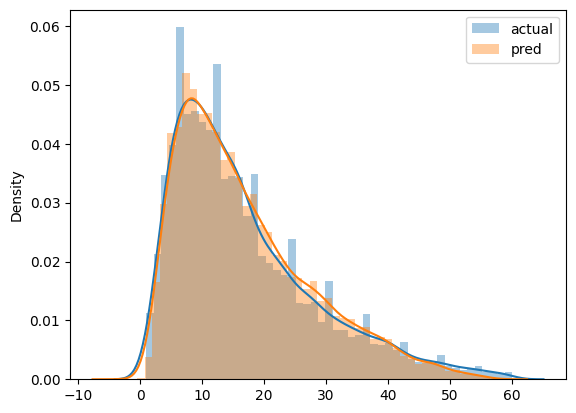

In [44]:
logged_model = '/workspaces/MLOps/01-intro/mlruns/3/324ff1de07134881b72dd65c29344d84/artifacts/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
pred = loaded_model.predict(X_test)

r2 = r2_score(y_test, pred)

print(f"R-squared: {r2}")

sns.distplot(y_test,kde=True,label='actual')
sns.distplot(pred,kde=True,label='pred')
plt.legend()